In [5]:
import formulaic
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")

observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'Coverage')

Module Matrix shape: (9360, 24)
Parameter Matrix shape: (9360, 12)
Interaction Matrix shape: (9360, 288)
Observation Matrix shape: (9360, 1)


,Coverage
0,0.666667
1,0.888889
2,0.888889
3,0.666667
4,0.600000
...,...
9355,0.750000
9356,0.869565
9357,0.222222
9358,0.600000


In [ ]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard Deviations for modules, marameters and nteractions
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 5.0)
    sigma_g = pm.Exponential('sigma_g', 5.0)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 10, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=observation_matrix['Coverage'])
    
    # Sample from the model
    trace = pm.sample(5, tune=5, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

### Save the results

In [2]:
import arviz as az

az.to_netcdf(trace, "final_coverage_model_single_parameter.nc")

NameError: name 'trace' is not defined

# Show the results


In [2]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp, logit_to_probability
import pandas as pd
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("model_3_trace_1000.nc")
variable_list = ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp']
transformations = {
    'a_m': logit_to_probability,
    #'a_bar': logit_to_probability,
    #'sigma_a': logit_to_probability
    #'b_p': log_to_exp
}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, ['a_m', 'a_bar', 'sigma_a', 'theta', 'sigma_b', 'b_p', 'sigma_g', 'g_mp'], hdi_prob=0.89)

In [3]:
from Notebooks.utils.summary_table_formatting import extract_column_names, update_table, replace_names, module_names_short, parameter_names_short


#print(module_matrix.columns)
module_names = extract_column_names(module_matrix.columns)
parameter_names = extract_column_names(parameter_matrix.columns)
interaction_names = extract_column_names(interaction_matrix.columns)

replace_names(module_names, module_names_short)
replace_names(parameter_names, parameter_names_short)
replace_names(interaction_names, module_names_short)
replace_names(interaction_names, parameter_names_short)

update_table(summary, 'a_m', module_names)
update_table(summary, 'b_p', parameter_names)
update_table(summary, 'g_mp', interaction_names)

summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[timer],0.873,0.003,0.869,0.878,0.000,0.000,4335.0,3269.0,1.00
a_m[decorators],0.663,0.005,0.655,0.670,0.000,0.000,4191.0,3059.0,1.00
a_m[namedtupleutils],0.933,0.002,0.930,0.936,0.000,0.000,4282.0,3040.0,1.00
a_m[packages],0.052,0.002,0.049,0.054,0.000,0.000,4376.0,3211.0,1.00
a_m[cmd],0.076,0.002,0.073,0.080,0.000,0.000,3549.0,2961.0,1.00
a_m[headers],0.598,0.005,0.590,0.605,0.000,0.000,4090.0,3121.0,1.00
a_m[h_base],0.747,0.004,0.741,0.754,0.000,0.000,4363.0,3136.0,1.00
a_m[da],0.793,0.004,0.787,0.799,0.000,0.000,4100.0,2740.0,1.00
a_m[py_base],0.279,0.004,0.272,0.285,0.000,0.000,4355.0,2783.0,1.00
a_m[dict_unpacking],0.140,0.003,0.135,0.145,0.000,0.000,4346.0,3220.0,1.00


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>]], dtype=object)

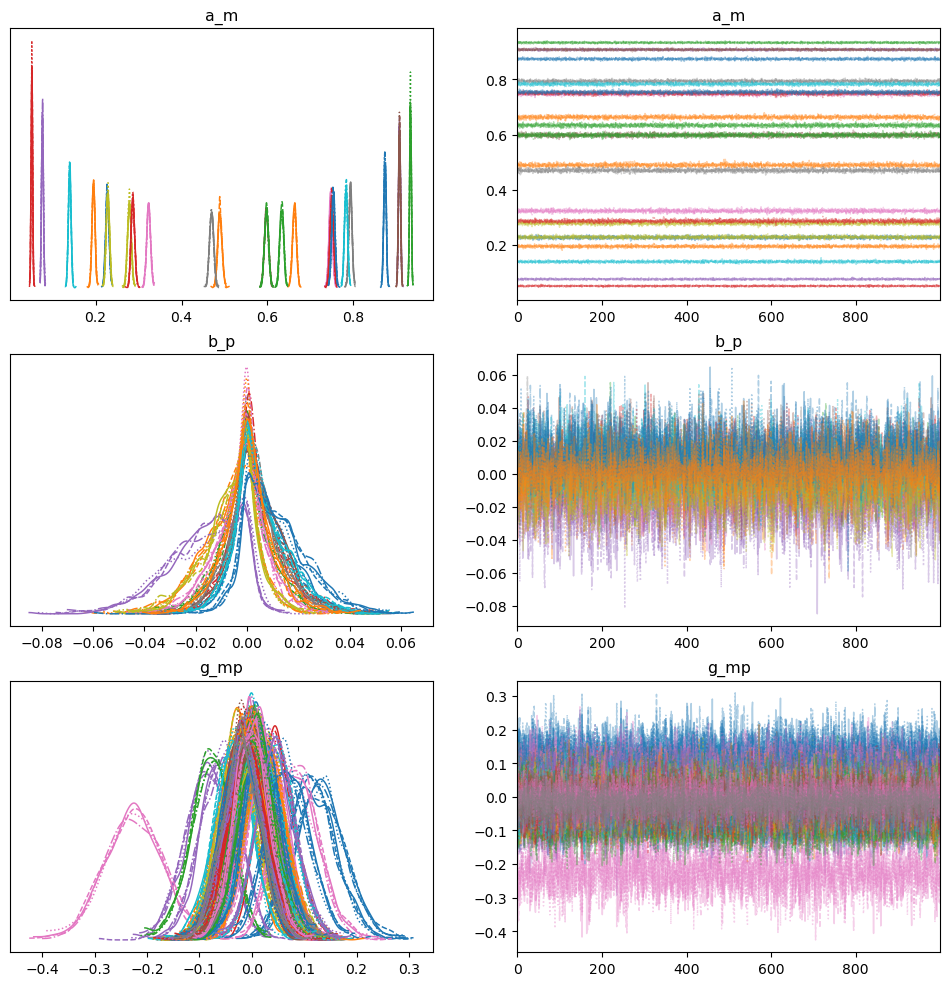

In [4]:
az.plot_trace(idata, var_names=['a_m', 'b_p', 'g_mp', ], figsize=(12, 12))

In [7]:
import arviz as az

az.to_netcdf(trace, "model_3_trace_1000.nc")

'model_3_trace_1000.nc'

In [8]:
az.loo(az.from_netcdf("model_3_trace_1000.nc"))

Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13388.16   235.42
p_loo      130.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma_a, sigma_b, sigma_g, theta]


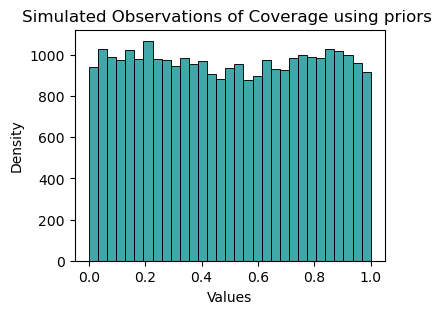

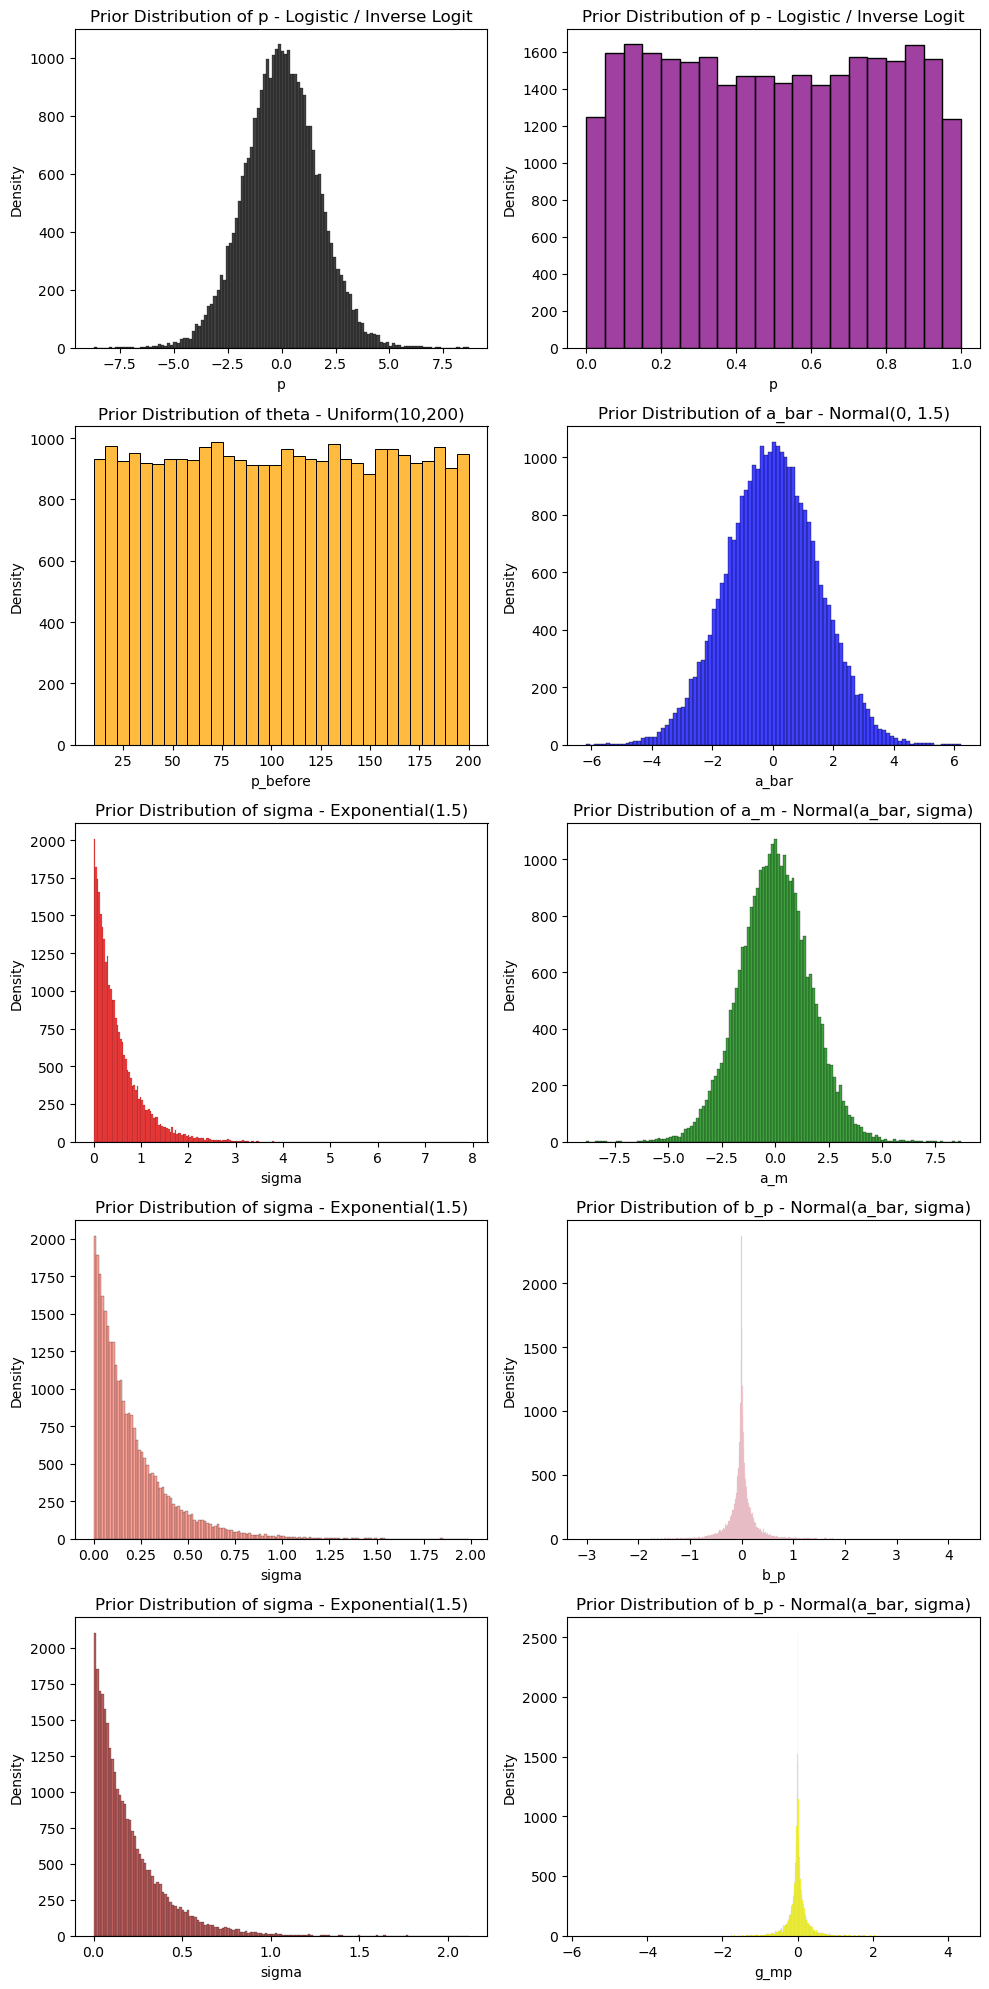

In [6]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def calc_prior_dist(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, max_theta):
    with pm.Model() as model:
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Non-centered parameterizations for module, parameter and interaction effect.
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)
        
        pm.Deterministic('p_before', (a_m + b_p + g_mp))

        # Link function (logit), unbounded to (0,1) probability
        pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        pm.Uniform('theta', 10, max_theta) # Disperion parameter

        # Sample Priors
        idata = pm.sample_prior_predictive(samples=30000)


    # Fetch and flatten priors
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()


    # Sample one data point from each combination
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    #Predicated observations
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Simulated Observations of Coverage using priors ', 'Values',
                                        'darkcyan', bin_range=(0, 1.0))
    observation_plot.plot()


    plots = [
        HistogramPlot(idata.prior['p_before'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'black'),
        HistogramPlot(idata.prior['p'].values.flatten(), 'Prior Distribution of p - Logistic / Inverse Logit', 'p', 'purple', bin_range=(0, 1), bins=20),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior Distribution of theta - Uniform(10,200)', 'p_before', 'orange'),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior Distribution of a_bar - Normal(0, 1.5)', 'a_bar', 'blue'),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'red'),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior Distribution of a_m - Normal(a_bar, sigma)', 'a_m', 'green'),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'b_p', 'pink'),
        HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior Distribution of sigma - Exponential(1.5)', 'sigma', 'brown'),
        HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior Distribution of b_p - Normal(a_bar, sigma)', 'g_mp', 'yellow')
    ]

    plot_histograms(plots, 5, 2, figsize=(10,20))


s_a = FloatSlider(value=2, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
s_b = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
s_g = FloatSlider(value=5, min=0.5, max=6, step=0.1, description='Sigma_gamma (sigma_g):')
a_bar_mu = FloatSlider(value=0, min=-2, max=2, step=0.1, description='alpha bar mu (a_bar_mu):')
a_bar_sigma = FloatSlider(value=1.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')
max_theta = FloatSlider(value=200, min=20, max=200, step=0.1, description='max bar sigma (a_bar_sigma):')



# Interactive sliders
#interact(calc_prior_dist, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma, max_theta=max_theta)
calc_prior_dist(2, 5, 5, 0, 1.5, 200)